#### loading the necessay packages

In [1]:
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


## Load Data

In [3]:
# load training and test data
import pickle
import numpy as np
from sklearn.preprocessing import label_binarize
import cv2

# resize input data to be 125*125
size = (125, 125)

data_train = pickle.load(open("data_dumped/image_data_train224.pkl","rb"))
data_test = pickle.load(open("data_dumped/image_data_test224.pkl","rb"))
class_list = pickle.load(open("data_dumped/class_list.pkl", "rb"))

# the data structure in image_data_train224.pkl
# it is a list of (image, label) tuple, each image is a matrix of (224, 224, 3)

X_train = np.array([cv2.resize(x[0], size)/255. for x in data_train])
X_test = np.array([cv2.resize(x[0], size)/255. for x in data_test])

Y_train = np.array([x[1] for x in data_train])
Y_test = np.array([x[1] for x in data_test])

print X_train.shape
print Y_train.shape
print X_test.shape
print Y_test.shape
print X_train.max()
print X_train.min()

(93, 125, 125, 3)
(93,)
(25, 125, 125, 3)
(25,)
1.0
0.0


## Load Model
We load the saved (pretrained) models in file 02 and 03.
1. file02: model 1, i.e. simple model, part of VGG, test accuracy on LFW: 0.51, training time shorter
2. file03: model 2, i.e. mobileNet, test accuracy on LFW: 0.64, training time longer

In [4]:
save_dir = os.path.join('saved_models')
model_name1 = 'keras_lfw_trained_model.h5'
model_name2 = 'keras_lfw_trained_model_150_mobileNet.h5'

### Model 1

In [5]:
from keras.models import load_model
model_path = os.path.join(save_dir, model_name1)
model_simple = load_model(model_path)

In [6]:
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 125, 125, 32)      896       
_________________________________________________________________
activation_25 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 123, 123, 32)      9248      
_________________________________________________________________
activation_26 (Activation)   (None, 123, 123, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 64)        18496     
__________

In [7]:
print [l.name for l in model_simple.layers]

[u'conv2d_17', u'activation_25', u'conv2d_18', u'activation_26', u'max_pooling2d_9', u'dropout_13', u'conv2d_19', u'activation_27', u'conv2d_20', u'activation_28', u'max_pooling2d_10', u'dropout_14', u'flatten_5', u'dense_9', u'activation_29', u'dropout_15', u'dense_10', u'activation_30']


In [8]:
import keras.backend as K
layer_name = 'activation_29'
get_embedding_layer_output = K.function([model_simple.layers[0].input, K.learning_phase()],
                                        [model_simple.get_layer(layer_name).output])

#### test the new model with one 'random' image
by >> x = np.random.rand(1,125,125,3);

In [9]:
import numpy as np
np.random.seed(1234)
x = np.random.rand(1,125,125,3)
layer_output_test = get_embedding_layer_output([x, 0])[0]

In [10]:
# Note that 0 refers to test, 1 refers to the training
print np.array(get_embedding_layer_output([x, 0])).shape
print np.array(get_embedding_layer_output([x, 1])).shape
# get_embedding_layer_output([x, 0])[0]

(1, 1, 512)
(1, 1, 512)


In [11]:
layer_output_test[0,:10]

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 4.329412, 0.      , 0.      ], dtype=float32)

#### now using the real training and test data
Note we include keras.function.learning_phase(), 1 means training, 0 means test.

<font color='red'>**However**</font>, we use static = 0 mode, in our case. There are three modes. It would affect some layers, e.g. the batch-normalization (BN) layer, dropout layer, etc. and then the final accuracy.
One could refer to the [blog](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/).

(93, 512)
(25, 512)


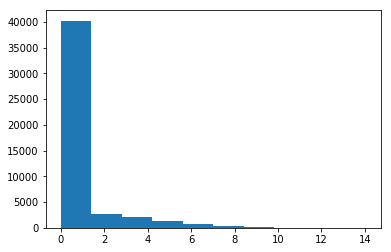

In [12]:
X_train_embedding = get_embedding_layer_output([X_train, ])[0]
X_test_embedding = get_embedding_layer_output([X_test, 0])[0]

print X_train_embedding.shape
print X_test_embedding.shape

plt.hist(X_train_embedding.ravel())
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression as LR

# it is identical to only optimize over the top layer
# previously the best we can get is 0.72 accuracy

model = LR()
model.fit(X_train_embedding, Y_train)
print "Part of VGG:\ntraining accuracy: ", model.score(X_train_embedding, Y_train)
print "test accuracy: ", model.score(X_test_embedding, Y_test)

Part of VGG:
training accuracy:  1.0
test accuracy:  0.84


/Users/lzq/anaconda3/envs/py27_faceRec/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lzq/anaconda3/envs/py27_faceRec/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


###  Model 2:  MobileNet

In [14]:
from keras.applications import mobilenet

model_path_mobileNet = os.path.join(save_dir, model_name2)
model_mobilenet = load_model(model_path_mobileNet, custom_objects={'relu6': mobilenet.relu6,
                                                                   'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

print model_mobilenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125, 125, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 127, 127, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 63, 63, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 63, 63, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 63, 63, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 65, 65, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 63, 63, 32)        288       
__________

Note:
#### batch normalization (BN) layer
To increase the stability of a neural network, batch normalization normalizes the output of a previous 
activation layer by subtracting the batch mean and dividing by the batch standard deviation.

In [15]:
import keras.backend as K
print K.learning_phase()

layer_name_mobilenet = 'global_average_pooling2d_1'
get_embedding_layer_output_mobilenet = K.function([model_mobilenet.layers[0].input, K.learning_phase()],
                                                  [model_mobilenet.get_layer(layer_name_mobilenet).output])

Tensor("dropout_13/keras_learning_phase:0", shape=(), dtype=bool)


(93, 1024)
(25, 1024)


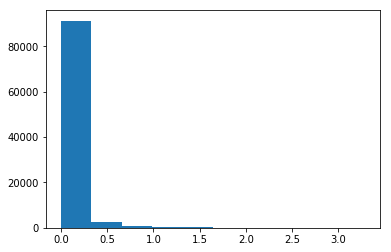

In [16]:
X_train_embedding_mobilenet = get_embedding_layer_output_mobilenet([X_train, 0])[0]
X_test_embedding_mobilenet = get_embedding_layer_output_mobilenet([X_test, 0])[0]

print X_train_embedding_mobilenet.shape
print X_test_embedding_mobilenet.shape

plt.hist(X_train_embedding_mobilenet.ravel())
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression as LR
# it is identical to only optimize over the top layer

model = LR()
model.fit(X_train_embedding_mobilenet, Y_train)
print "Pretrained MobileNet:\ntraining accuracy: ", model.score(X_train_embedding_mobilenet, Y_train)
print "test accuracy: ", model.score(X_test_embedding_mobilenet, Y_test)

Pretrained MobileNet:
training accuracy:  0.7634408602150538
test accuracy:  0.6


### Model 3: simple logistic regression 

In [18]:
model = LR()
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train)
print "Logisic Regression\n training accuracy: ", model.score(X_train.reshape(X_train.shape[0],-1), Y_train)
print "test accuracy: ", model.score(X_test.reshape(X_test.shape[0],-1), Y_test)

Logisic Regression
 training accuracy:  1.0
test accuracy:  0.88


## conclusion: 
1. Pretraining may help deep network training, but it requires longer and finer training. A finer transfering would be applied in the "FaceRecog05_*.".
2. In our case, a noisy pretraining, part of VGG and MobileNet, cannot beat even logistic regression, 